In [1]:
from collections import namedtuple, OrderedDict
from dataclasses import dataclass
from rdkit import Chem
from typing import Optional, List, Tuple
from rdkit.Chem import rdFMCS, AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
import pandas as pd
import yaml
import bcs

[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.
[11:30:14] product atom-mapping number 10 not found in reactants.


In [2]:
def load_config(config_path="config.yaml"):
    """
    Load parameters from a YAML config file
    """
    with open(config_path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

config = load_config("/home/kroberts/PythonProject/RetroTideV2/krswaps/test_set/cryptofolione.yaml")

In [3]:
def modify_bcs_starters_extenders(starter_codes: Optional[List[str]] = None,
                                  extender_codes: Optional[List[str]] = None):
    """
    Modifies the starter and extender units available for RetroTide.
    Removes all starter and extender units not specifed in the input lists.
    """
    for key in list(bcs.starters.keys()):
        if key not in starter_codes:
            bcs.starters.pop(key, None)
    for key in list(bcs.extenders.keys()):
        if key not in extender_codes:
            bcs.extenders.pop(key, None)

modify_bcs_starters_extenders(starter_codes = config["starter_codes"],
                              extender_codes = config["extender_codes"])

In [4]:
from retrotide import structureDB, designPKS, compareToTarget

["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", "DH{'type': 'E'}", "ER{'type': 'D'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", "DH{'type': 'E'}", "ER{'type': 'L'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", "DH{'type': 'Z'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", "DH{'type': 'E'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", 'loading: False']


Canonicalize user-specified target molecule SMILES

In [5]:
def canonicalize_smiles(molecule_str: str, stereo: str) -> str:
    """
    Standardizes a SMILES string and returns its canonical form with the
    specified isomeric information.
    
    Args:
        molecule_str (str): The SMILES string of the target molecule
        stereo (str): The type of stereochemistry to specify

    Returns:
        str: The canonicalized SMILES string
    """
    mol = Chem.MolFromSmiles(molecule_str)
    if stereo == 'R/S':
        target = Chem.MolToSmiles(mol, isomericSmiles=True).replace('/', '').replace('\\', '')
    elif stereo == 'E/Z':
        target = Chem.MolToSmiles(mol, isomericSmiles=True).replace('@', '').replace('@@', '')
    elif stereo == 'none':
        target = Chem.MolToSmiles(mol, isomericSmiles=False)
    elif stereo == 'all':
        target = Chem.MolToSmiles(mol, isomericSmiles=True) 
    else:
        raise ValueError("Invalid stereo option. Choose from 'R/S', 'E/Z', 'none', or 'all'.")
    return target

Run RetroTide for retrosynthesis

In [6]:
def initial_pks(target: str) -> tuple[list, Chem.Mol]:
    """
    Computes a PKS design to synthesize the 2D structure of the target molecule

    Args:
        target (str): The SMILES string of the target molecule

    Returns:
        pks_design: Initial RetroTide proposed PKS design
        mol (Chem.Mol): The computed product of the PKS design
    """
    designs = designPKS(Chem.MolFromSmiles(target),
                        maxDesignsPerRound = 500,
                        similarity = 'mcs_without_stereo')
    pks_design = designs[-1][0][0].modules
    mol = designs[-1][0][0].computeProduct(structureDB)
    return pks_design, mol

In [7]:
smiles = canonicalize_smiles(config["molecule"], config["stereo"])

In [8]:
offload_mech = config["offload_mech"]

In [9]:
pks_design, pks_product = initial_pks(smiles)

computing module 1
   testing 7 designs
   best score is 0.5217391304347826
computing module 2
   testing 49 designs
   best score is 0.6521739130434783
computing module 3
   testing 343 designs
   best score is 0.7391304347826086
computing module 4
   testing 2401 designs
   best score is 0.8695652173913043
computing module 5
   testing 3500 designs
   best score is 0.9565217391304348
computing module 6
   testing 3500 designs
   best score is 0.92


Offload the RetroTide predicted PKS Product

In [10]:
def substructure_search(mol: Chem.Mol, pattern: str):
    """
    Helper function. Identify substructure matches
    """
    pattern_mol = Chem.MolFromSmarts(pattern)
    matches = mol.GetSubstructMatches(pattern_mol)
    return matches

In [11]:
def lactone_size(mol: Chem.Mol, pattern_matches: tuple) -> int:
    """
    Identify the size of the largest lactone in the target molecule
    """
    ring_info = mol.GetRingInfo()
    lactone_sizes = []
    if ring_info.AtomRings():
        for ring in ring_info.AtomRings():
            if any(idx in ring for match in pattern_matches for idx in match):
                lactone_sizes.append((len(ring) - 1))
            else:
                lactone_sizes.append(int(0))
    if lactone_sizes:
        return max(lactone_sizes), ring
    return 0, None

In [12]:
def te_offload(pks_product: Chem.Mol, mol: Chem.Mol, release_mechanism: str) -> tuple:
    Chem.SanitizeMol(pks_product)
    thioester_pattern = '[C:1](=[O:2])[S:3]'
    thioester_matches = substructure_search(pks_product, thioester_pattern)
    c_idx, o_idx, s_idx = thioester_matches[0]
    carbonyl_c_idx = thioester_matches[0][0]
    if not thioester_matches:
        print("Warning: No thioester found")
        return (pks_product,)

    if release_mechanism == 'thiolysis':
        editable_product = Chem.EditableMol(pks_product)
        editable_product.RemoveBond(c_idx, s_idx)
        editable_product.RemoveAtom(s_idx)
        acid_o_idx = editable_product.AddAtom(Chem.Atom('O'))
        editable_product.AddBond(c_idx, acid_o_idx, Chem.rdchem.BondType.SINGLE)
        unbound_mol = editable_product.GetMol()
        Chem.SanitizeMol(unbound_mol)
        return (unbound_mol,)

    if release_mechanism == 'cyclization':
        ester_pattern = '[C:1](=[O:2])[O:3][C:4]'
        ester_matches = substructure_search(mol, ester_pattern)
        target_size = lactone_size(mol, ester_matches)[0]
        if target_size != 0:
            hydroxyl_pattern = '[OH1]'
            hydroxyl_matches = substructure_search(pks_product, hydroxyl_pattern)
            if not hydroxyl_matches:
                print("Warning: No hydroxyl groups found. Cannot cyclize")
                return(pks_product,)
            for hydroxyl in hydroxyl_matches:
                hydroxyl_o_idx = hydroxyl[0]
                distance = len(Chem.GetShortestPath(pks_product, carbonyl_c_idx, hydroxyl_o_idx)) - 1
                if distance == target_size:
                    editable_product = Chem.EditableMol(pks_product)
                    editable_product.RemoveBond(carbonyl_c_idx, s_idx)
                    editable_product.AddBond(carbonyl_c_idx, hydroxyl_o_idx, Chem.rdchem.BondType.SINGLE)
                    editable_product.RemoveAtom(s_idx)
                    unbound_mol = editable_product.GetMol()
                    Chem.SanitizeMol(unbound_mol)
                    return (unbound_mol,)
            print(f"No hydroxyl group found at the target distance {target_size}. Cannot cyclize")
            return (pks_product,)
        print("Warning: No valid lactone found in target")
        return (pks_product,)
    return (unbound_mol,)
        

In [13]:
test_mol = Chem.MolFromSmiles(smiles)

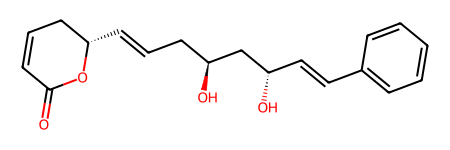

In [14]:
test_mol

Insert Z alkene / \ into target lactone ring , if len(ring) <= 6. Add double bond labels

In [15]:
def add_atom_labels(mol: Chem.Mol, chiral_centers: dict) -> Chem.Mol:
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_label = f'{atom.GetSymbol()}:{atom_idx}'
        if atom_idx in chiral_centers:
            cip_label = f'{atom_label} ({chiral_centers[atom_idx]})'
        else:
            cip_label = atom_label
        atom.SetProp('atomNote', cip_label)
    return mol

Atom and module map the PKS product

In [16]:
# Helper function: MCS search
def mcs_search(mol_1: Chem.Mol, mol_2: Chem.Mol, chiral: bool) -> tuple[int, Chem.Mol]:
    mcs = rdFMCS.FindMCS(
        [mol_1, mol_2],
        timeout=10,
        matchValences=True,
        matchChiralTag=chiral,
        bondCompare=Chem.rdFMCS.BondCompare.CompareOrderExact,
        ringMatchesRingOnly=False
        )
    atom_ct = mcs.numAtoms
    smarts = Chem.MolFromSmarts(mcs.smartsString)
    return atom_ct, smarts

In [17]:
def module_map_product(pks_design: list) -> Chem.Mol:
    """
    Maps atoms of the PKS product to each module in the PKS design.

    Args:
        pks_design (list): The RetroTide proposed PKS design

    Returns:
        mapped_product (Chem.Mol): An atom-module mapped PKS product
    """
    cluster = bcs.Cluster(modules = pks_design)
    mapped_product = bcs.Cluster.create_atom_maps(cluster, structureDB)[-1]
    return mapped_product

In [18]:
def module_map(unbound_mol: Chem.Mol) -> pd.DataFrame:
    module_map_df = pd.DataFrame(columns=['Atom Type', 'Product Atom Idx', 'Module Idx'])
    for i, atom in enumerate(unbound_mol.GetAtoms()):
        if not atom.HasProp('atomLabel'):
            module = '-'
        else:
            module = atom.GetProp('atomLabel')
        atom_entry = pd.DataFrame({
            'Atom Type': [atom.GetSymbol()],
            'Product Atom Idx': [atom.GetIdx()],
            'Module Idx': [module]
        },
        index = [i])
        module_map_df = pd.concat([module_map_df, atom_entry])
    return module_map_df

def atom_map(unbound_mol: Chem.Mol, mol: Chem.Mol) -> pd.DataFrame:
    """"
    Uses maximum common substructure search to map atoms of the offloaded
    PKS product to the target molecule

    Args:
        unbound_mol (Chem.Mol): The unbound PKS product
        target_mol (Chem.Mol): The target molecule

    Returns:
        mcs_mapped_atoms_df (pd.DataFrame): DataFrame containing atom type,
        product atom index, and target atom index
    """
    atom_map_df = pd.DataFrame(columns=['Atom Type', 'Product Atom Idx', 'Target Atom Idx'])
    mcs_atoms, mcs_smarts = mcs_search(unbound_mol, mol, False)
    if mcs_atoms > 0:
        mol_1_match = unbound_mol.GetSubstructMatch(mcs_smarts)
        mol_2_match = mol.GetSubstructMatch(mcs_smarts)
        for i, (idx_1, idx_2) in enumerate(zip(mol_1_match, mol_2_match)):
            atom_entry = pd.DataFrame({
                'Atom Type': unbound_mol.GetAtomWithIdx(idx_1).GetSymbol(),
                'Product Atom Idx': idx_1,
                'Target Atom Idx': idx_2
            },
            index = [i])
            atom_map_df = pd.concat([atom_map_df, atom_entry], ignore_index=True)
    else:
        print("Warning: No common substructure found between the PKS product and target molecule")
        return atom_map_df
    return atom_map_df

def full_map(atom_map: pd.DataFrame, module_map: pd.DataFrame) -> pd.DataFrame:
    """
    Merge PKS product atom and module mapping
    """
    full_map = pd.merge(
        atom_map,
        module_map,
        on=['Atom Type', 'Product Atom Idx']).dropna()
    return full_map

mapped_mol = module_map_product(pks_design)

Assess stereochemistry correspondence

In [19]:
ChiralCheckResult = namedtuple('ChiralCheckResult',
                               ['match1', 'match2', 'mmatch1', 'mmatch2', 'cc1', 'cc2'])

def get_rs_stereo_correspondence(unbound_mol: Chem.Mol, mol: Chem.Mol, full_map: pd.DataFrame) -> ChiralCheckResult:
    """
    Checks chirality of mapped atoms between the PKS product and target molecule

    Returns:
        ChiralCheckResult: A named tuple containing lists of matching and mismatching atom indices
        and dicts of chiral centers
    """
    cc1 = dict(Chem.FindMolChiralCenters(unbound_mol, includeUnassigned=True))
    cc2 = dict(Chem.FindMolChiralCenters(mol, includeUnassigned=True))
    match1 = []
    match2 = []
    mmatch1 = []
    mmatch2 = []

    product_atoms = full_map['Product Atom Idx'].astype(int).tolist()
    target_atoms = full_map['Target Atom Idx'].astype(int).tolist()
    for idx1, idx2 in zip(product_atoms, target_atoms):
        if idx1 in cc1 and idx2 in cc2:
            if cc1[idx1] == cc2[idx2]:
                match1.append(idx1)
                match2.append(idx2)
            else:
                mmatch1.append(idx1)
                mmatch2.append(idx2)
    return ChiralCheckResult(match1, match2, mmatch1, mmatch2, cc1, cc2)


In [20]:
def extract_ez_atoms(mol: Chem.Mol) -> Tuple[list, list]:
    """
    Helper function to identify atoms involved in Z and E alkenes present.
    Adds bondNote to assign CIP label to each alkene
    """
    z_bonds = []
    e_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            stereo = bond.GetStereo()
            begin_idx = bond.GetBeginAtomIdx()
            end_idx = bond.GetEndAtomIdx()
            if stereo == Chem.BondStereo.STEREOZ:
                z_bonds.extend([begin_idx, end_idx])
                bond.SetProp('bondNote', '(Z)')
            elif stereo == Chem.BondStereo.STEREOE:
                e_bonds.extend([begin_idx, end_idx])
                bond.SetProp('bondNote', '(E)')
    return z_bonds, e_bonds

AlkeneCheckResult = namedtuple('AlkeneCheckResult',
                                ['match1', 'match2', 'mmatch1', 'mmatch2'])

def get_ez_stereo_correspondence(unbound_mol: Chem.Mol, mol: Chem.Mol, full_map: pd.DataFrame) -> AlkeneCheckResult:
    """
    Checks alkene stereochemistry correspondence between the PKS product and target molecule

    Returns:
        AlkeneCheckResult: A named tuple containing lists of matching and mismatching atom indices
        and dicts of double bonds
    """
    z_1, e_1 = extract_ez_atoms(unbound_mol)
    z_2, e_2 = extract_ez_atoms(mol)
    match1 = []
    match2 = []
    mmatch1 = []
    mmatch2 = []

    product_atoms = full_map['Product Atom Idx'].astype(int).tolist()
    target_atoms = full_map['Target Atom Idx'].astype(int).tolist()
    for idx1, idx2 in zip(product_atoms, target_atoms):
        if idx1 in z_1 + e_1 and idx2 in z_2 + e_2:
            if (idx1 in z_1 and idx2 in z_2) or (idx1 in e_1 and idx2 in e_2):
                match1.append(idx1)
                match2.append(idx2)
            else:
                mmatch1.append(idx1)
                mmatch2.append(idx2)
    return AlkeneCheckResult(match1, match2, mmatch1, mmatch2)

In [21]:
def get_lactone_atoms(mol: Chem.Mol) -> tuple:
    ester_matches = substructure_search(
        mol, '[C:1](=[O:2])[O:3][C:4]')
    return lactone_size(mol, ester_matches)[1]

def force_z_alkene(mol: Chem.Mol, lactone_atoms: tuple):
    """
    Force the alkene within the lactone to be Z stereochemistry
    """
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    if len(lactone_atoms) <= 6:
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.BondType.DOUBLE:
                begin_idx = bond.GetBeginAtomIdx()
                end_idx = bond.GetEndAtomIdx()
                if begin_idx in lactone_atoms and end_idx in lactone_atoms:
                    bond.SetStereo(Chem.BondStereo.STEREOZ)
    return mol

def find_target_lactone(lactone_atoms: tuple, full_map: pd.DataFrame) -> tuple:
    target_z_atoms = set()
    for atom in lactone_atoms:
        target_idx = full_map.loc[full_map['Product Atom Idx'] == atom, 'Target Atom Idx']
        target_z_atoms.add(int(target_idx))
    return tuple(target_z_atoms)

In [22]:
# Identify target PKS precursor
def pks_precursor_atoms(unbound_mol: Chem.Mol, mol: Chem.Mol) -> set:
    mcs_atoms, mcs_smarts = mcs_search(unbound_mol, mol, False)
    if mcs_atoms > 0:
        precursor_atoms = set(mol.GetSubstructMatch(mcs_smarts))
    else:
        precursor_atoms = set()
    return precursor_atoms

def extract_precursor_mol(mol: Chem.Mol, precursor_atoms: set) -> Chem.Mol:
    mol_copy = Chem.Mol(mol)
    for atom in mol_copy.GetAtoms():
        atom.SetIntProp("original_idx", atom.GetIdx())
    editable_target = Chem.EditableMol(mol_copy)
    break_bonds = []
    for bond in mol_copy.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()
        if (idx1 in precursor_atoms) != (idx2 in precursor_atoms):
            break_bonds.append((idx1, idx2))
    for idx1, idx2 in break_bonds:
        editable_target.RemoveBond(idx1, idx2)
    original_atoms = set(range(mol.GetNumAtoms()))
    remove_atoms = sorted(original_atoms - precursor_atoms, reverse=True)
    for atom_idx in remove_atoms:
        editable_target.RemoveAtom(atom_idx)
    precursor_mol = editable_target.GetMol()
    try:
        Chem.SanitizeMol(precursor_mol,
                         sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_VALENCE)
    except Exception:
        try:
            Chem.SanitizeMol(precursor_mol,
                             sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_PROPERTIES^Chem.SANITIZE_VALENCE)
        except Exception:
            pass
    return precursor_mol

def check_for_precursor(unbound_mol: Chem.Mol, mol: Chem.Mol):
    mcs_score = compareToTarget(unbound_mol, mol, 'mcs_without_stereo')
    if mcs_score < 1.0:
        print(f'The PKS product only matches {mcs_score*100:.1f}% of the 2D target molecule.')
        print(f'Extracting the PKS precursor from the target molecule.')
        precursor_atoms = pks_precursor_atoms(unbound_mol, mol)
        precursor_mol = extract_precursor_mol(mol, precursor_atoms)
        return precursor_mol
    return mol

In [23]:
def get_design_features(pks_design: list) -> dict:
    """
    Constructs a dictionary containing information about the PKS design

    Args:
        pks_design (list): Initial RetroTide design

    Returns:
        pks_features (dict): Dictionary with information about the intial PKS design,
        including module number, substrate, KR, DH, and ER subtypes, and whether DH
        or ER domains are present.
    """
    pks_features = {
        'Module': [],
        'Substrate': [],
        'KR Type': [],
        'DH Type': [],
        'ER Type': [],
    }
    for idx, module in enumerate(pks_design):
        pks_features['Module'].append(idx)
        pks_features['Substrate'].append(module.domains[bcs.AT].substrate)
        if bcs.KR in module.domains:
            pks_features['KR Type'].append(module.domains[bcs.KR].type)
            if bcs.DH in module.domains:
                pks_features['DH Type'].append(module.domains[bcs.DH].type)
            else:
                pks_features['DH Type'].append('None')
            if bcs.ER in module.domains:
                pks_features['ER Type'].append(module.domains[bcs.ER].type)
            else:
                pks_features['ER Type'].append('None')
        else:
            pks_features['KR Type'].append('None')
            pks_features['DH Type'].append('None')
            pks_features['ER Type'].append('None')
    return pks_features

In [24]:
pks_features = get_design_features(pks_design)
pks_features

{'Module': [0, 1, 2, 3, 4, 5],
 'Substrate': ['cin',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA'],
 'KR Type': ['None', 'B', 'B', 'A', 'B', 'A'],
 'DH Type': ['None', 'None', 'None', 'Z', 'None', 'Z'],
 'ER Type': ['None', 'None', 'None', 'None', 'None', 'None']}

In [25]:
# Helper function
def get_mod_number(module_label: str) -> int:
    if module_label == 'LM':
        return 0
    else:
        return int(module_label.lstrip('M'))

In [26]:
def force_pks_lactone_alkene(mol: Chem.Mol, lactone_atoms: tuple, full_map: pd.DataFrame, pks_features: dict):
    """
    Force lactone alkene stereochemistry based on the responsible DH subtype in the original PKS design
    """
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    if len(lactone_atoms) <= 6:
        for bond in mol.GetBonds():
            if bond.GetBondType() == Chem.BondType.DOUBLE:
                begin_idx = bond.GetBeginAtomIdx()
                end_idx = bond.GetEndAtomIdx()
                if begin_idx in lactone_atoms and end_idx in lactone_atoms:
                    begin_module = get_mod_number(full_map.loc[full_map['Product Atom Idx'] == begin_idx, 'Module Idx'].values[0])
                    end_module = get_mod_number(full_map.loc[full_map['Product Atom Idx'] == end_idx, 'Module Idx'].values[0])
                    target_module = begin_module if begin_module > end_module else end_module
                    dh_subtype = pks_features['DH Type'][target_module]
                    if dh_subtype == 'Z':
                        bond.SetStereo(Chem.BondStereo.STEREOZ)
                    elif dh_subtype == 'E':
                        bond.SetStereo(Chem.BondStereo.STEREOE)
    return mol

In [27]:
def preprocessing(pks_design: Chem.Mol, target: Chem.Mol, offload_mech: str):
    mapped_product = module_map_product(pks_design)
    unbound_mol = te_offload(mapped_product, target, offload_mech)[0]
    target = check_for_precursor(unbound_mol, target) # Comment out if precursor extraction not desired
    module_mapped_df = module_map(unbound_mol)
    atom_mapped_df = atom_map(unbound_mol, target)
    full_mapped_df = full_map(atom_mapped_df, module_mapped_df)
    pks_features = get_design_features(pks_design)
    lactone_atoms = get_lactone_atoms(unbound_mol)
    target_lactone_atoms = find_target_lactone(lactone_atoms, full_mapped_df)
    unbound_mol = force_pks_lactone_alkene(unbound_mol, lactone_atoms, full_mapped_df, pks_features)
    target_mol = force_z_alkene(target, target_lactone_atoms)
    chiral_results = get_rs_stereo_correspondence(unbound_mol, target_mol, full_mapped_df)
    alkene_results = get_ez_stereo_correspondence(unbound_mol, target_mol, full_mapped_df)
    return unbound_mol, target_mol, chiral_results, alkene_results, full_mapped_df

unbound_mol, target_mol, chiral_results, alkene_results, full_mapped_df = preprocessing(pks_design, test_mol, offload_mech)

In [28]:
def extract_carbon_pairs(mol: Chem.Mol, full_map: pd.DataFrame) -> list:
    carbons = {}
    for _, row in full_map.iterrows():
        if row['Atom Type'] == 'C':
            c_idx = int(row['Product Atom Idx'])
            carbons[c_idx] = row['Module Idx']
    
    backbone_pairs = []
    for c_idx in carbons.keys():
        c_atom = mol.GetAtomWithIdx(c_idx)
        for neighbor in c_atom.GetNeighbors():
            if neighbor.GetSymbol() == 'C' and neighbor.GetIdx() in carbons.keys():
                neighbor_mod = carbons[neighbor.GetIdx()]
                if neighbor_mod != carbons[c_idx]:
                    pair = tuple(sorted([(c_idx, carbons[c_idx]), (neighbor.GetIdx(), neighbor_mod)]))
                    if pair not in backbone_pairs:
                        backbone_pairs.append(pair)
    return backbone_pairs

In [29]:
backbone_pairs = extract_carbon_pairs(unbound_mol, full_mapped_df)

In [30]:
def identify_pairs_with_mismatches(backbone_pairs: list, mmatch1: list) -> list:
    mismatch_pairs = []
    for pair in backbone_pairs:
        if pair[0][0] in mmatch1 or pair[1][0] in mmatch1:
            mismatch_pairs.append(pair)
    return mismatch_pairs

In [31]:
cc_mmatch1 = chiral_results.mmatch1
alkene_mmatch1 = alkene_results.mmatch1
cc_mismatch_pairs = identify_pairs_with_mismatches(backbone_pairs, cc_mmatch1)
alkene_mismatch_pairs = identify_pairs_with_mismatches(backbone_pairs, alkene_mmatch1)
print(cc_mismatch_pairs)
print(alkene_mismatch_pairs)

[((8, 'LM'), (9, 'M1')), ((16, 'M3'), (17, 'M4'))]
[((14, 'M2'), (15, 'M3'))]


In [32]:
alkene_mmatch1

[14, 15]

Identify mismatch case

In [33]:
def check_alpha_carbon_mismatch(mol: Chem.Mol, pair: tuple, cc_mmatch1: list) -> dict:
    alpha_carbon_patterns = [
        '[C:1][C:2](=[O:3])',
        '[C:1][C:2][OH:3]',
        '[C:1][C:2][O:3]',
        '[C:1][C:2](=[O:3])[O:4][C:5]',
        '[C:1]/[C:2]=[C:3]/[C:4]',
        '[C:1]/[C:2]=[C:3]\[C:4]',
        '[C:1]([CH2:2])[CH2:3]'
    ]
    substructure_results = {'atom1': False, 'atom2': False}
    for pattern in alpha_carbon_patterns:
        matches = substructure_search(mol, pattern)
        for match in matches:
            if pair[0][0] == match[0] and pair[0][0] in cc_mmatch1:
                substructure_results.update({
                    'atom1': True
                })
            if pair[1][0] == match[0] and pair[1][0] in cc_mmatch1:
                substructure_results.update({
                    'atom2': True
                })
    return substructure_results

def check_beta_carbon_mismatch(mol: Chem.Mol, pair: tuple, cc_mmatch1: list) -> dict:
    beta_carbon_patterns = [
        '[C:1][OH:2]',
        '[C:1][O:2][C:3](=[O:4])'
    ]
    substructure_results = {'atom1': False, 'atom2': False}
    for pattern in beta_carbon_patterns:
        matches = substructure_search(mol, pattern)
        for match in matches:
            if pair[0][0] == match[0] and pair[0][0] in cc_mmatch1:
                substructure_results.update({
                    'atom1': True
                })
            if pair[1][0] == match[0] and pair[1][0] in cc_mmatch1:
                substructure_results.update({
                    'atom2': True
                })
    return substructure_results

def check_alkene_mismatch(mol: Chem.Mol, pair: tuple, alkene_mmatch1: list) -> dict:
    alkene_pattern = '[C:1]=[C:2]'
    substructure_results = {'atom1': False, 'atom2': False}
    matches = substructure_search(mol, alkene_pattern)
    for match in matches:
        if pair[0][0] == match[0] and pair[0][0] in alkene_mmatch1:
            substructure_results.update({
                'atom1': True
            })
        if pair[1][0] == match[0] and pair[1][0] in alkene_mmatch1:
            substructure_results.update({
                'atom2': True
            })
    return substructure_results

def check_cc_mismatch_cases(mol: Chem.Mol, cc_mismatch_pairs: list, cc_mmatch1: list) -> list:
    cc_mismatch_results = []
    for pair in cc_mismatch_pairs:
        pair_info = {
            'c_idx_i': pair[0][0],
            'module_i': pair[0][1],
            'c_idx_i+1': pair[1][0],
            'module_i+1': pair[1][1],
            'alpha_mismatch' : False,
            'beta_mismatch' : False,
            }
        alpha_results = check_alpha_carbon_mismatch(mol, pair, cc_mmatch1)
        beta_results = check_beta_carbon_mismatch(mol, pair, cc_mmatch1)
        if (alpha_results['atom1'] is True) or (alpha_results['atom2'] is True):
            pair_info.update({
                'alpha_mismatch': True
            })
        if (beta_results['atom1'] is True) or (beta_results['atom2'] is True):
            pair_info.update({
                'beta_mismatch': True
            })
        cc_mismatch_results.append(pair_info)
    return cc_mismatch_results

def check_alkene_mismatch_cases(mol: Chem.Mol, alkene_mismatch_pairs: list, alkene_mmatch1: list) -> list:
    alkene_mismatch_results = []
    for pair in alkene_mismatch_pairs:
        pair_info = {
            'c_idx_i': pair[0][0],
            'module_i': pair[0][1],
            'c_idx_i+1': pair[1][0],
            'module_i+1': pair[1][1],
            'alkene_mismatch': False
        }
        alkene_results = check_alkene_mismatch(mol, pair, alkene_mmatch1)
        if (alkene_results['atom1'] is True) or (alkene_results['atom2'] is True):
            pair_info.update({
                'alkene_mismatch': True
            })
        alkene_mismatch_results.append(pair_info)
    return alkene_mismatch_results


In [34]:
cc_mmatch1 = chiral_results.mmatch1
alkene_mmatch1 = alkene_results.mmatch1

In [35]:
cc_mismatch_results = check_cc_mismatch_cases(unbound_mol, cc_mismatch_pairs, cc_mmatch1)
alkene_mismatch_results = check_alkene_mismatch_cases(unbound_mol, alkene_mismatch_pairs, alkene_mmatch1)
print(cc_mismatch_results)
print(alkene_mismatch_results)

[{'c_idx_i': 8, 'module_i': 'LM', 'c_idx_i+1': 9, 'module_i+1': 'M1', 'alpha_mismatch': False, 'beta_mismatch': True}, {'c_idx_i': 16, 'module_i': 'M3', 'c_idx_i+1': 17, 'module_i+1': 'M4', 'alpha_mismatch': False, 'beta_mismatch': True}]
[{'c_idx_i': 14, 'module_i': 'M2', 'c_idx_i+1': 15, 'module_i+1': 'M3', 'alkene_mismatch': True}]


In [36]:
def kr_type_logic(pks_features: dict, target_mod: int, alpha: bool, beta: bool) -> str:
    old_kr_type = pks_features['KR Type'][target_mod]
    substrate = pks_features['Substrate'][target_mod]
    new_kr_type = None
    # Single cases
    if (substrate == 'Malonyl-CoA' and pks_features['ER Type'][target_mod] == 'None'):
        if old_kr_type == 'A':
            new_kr_type = 'B'
        else:
            new_kr_type = 'A'
        print('    Case 1: No alpha substituent. Only beta is wrong -> swapping letter only')
    elif (substrate == 'Malonyl-CoA' and pks_features['ER Type'][target_mod] != 'None'):
        new_kr_type = 'B'
    elif (substrate == 'Methylmalonyl-CoA' and pks_features['DH Type'][target_mod] != 'None'):
        new_kr_type = 'B1'
    # Complex cases
    elif old_kr_type is None:
        if alpha:
            new_kr_type = 'C2'
            print('    Case 5: Adding KR type C2 to perform epimerization of the alpha chiral center')
        else:
            print('    No KR domain and not an alpha carbon mismatch -> cannot fix by KR swap')
    else:
        letter = old_kr_type[0]
        number = old_kr_type[1:] if len(old_kr_type) >= 2 else '1'
        if alpha and beta:
            new_letter = 'B' if letter == 'A' else 'A'
            new_number = '2' if number == '1' else '1'
            new_kr_type = new_letter + new_number
            print('    Case 4: Both are wrong -> swapping both letter and number')
        elif alpha and not beta:
            new_number = '2' if number == '1' else '1'
            new_kr_type = letter + new_number
            print('    Case 3: Only alpha is wrong -> swapping number only')
        elif not alpha and beta:
            new_letter = 'B' if letter == 'A' else 'A'
            new_kr_type = new_letter + number
            print('    Case 2: Only beta is wrong -> swapping letter only')
        else:
            new_kr_type = old_kr_type
            print('    No case found -> returning the original KR type')
    return new_kr_type

def er_type_logic(pks_features: dict, target_mod: int) -> str:
    old_er_type = pks_features['ER Type'][target_mod]
    new_er_type = None
    substrate = pks_features['Substrate'][target_mod]
    if substrate != 'Malonyl-CoA':
        new_er_type = 'D' if old_er_type == 'L' else 'L'
        print('   Case 7: Swapping ER subtypes')
    else:
        return old_er_type # ER subtype can be ignored as malonyl-CoA has no alpha chiral center
    return new_er_type

def kr_dh_type_logic(pks_features: dict, target_mod: int) -> str:
    old_dh_type = pks_features['DH Type'][target_mod]
    new_kr_type, new_dh_type = None, None
    substrate = pks_features['Substrate'][target_mod]
    if substrate != 'Malonyl-CoA':
        new_kr_type, new_dh_type = 'B1', 'E'
    else:
        print('    Case 6: Swapping DH-KR subtypes')
        if old_dh_type == 'Z':
            new_kr_type, new_dh_type = 'B', 'E'
        else:
            new_kr_type, new_dh_type = 'A', 'Z'
    return new_kr_type, new_dh_type

In [37]:
def identify_kr_swap_case(pks_features: dict, result: dict):
    """
    Assess if the mismatched stereocenter is alpha or beta
    Select the correct KR swap to make accordingly
    """
    target_mod = get_mod_number(result['module_i+1'])
    old_kr_type = pks_features['KR Type'][target_mod]

    print(f'----Analyzing mismatch(s) in pair ({result["c_idx_i"]}, {result["c_idx_i+1"]})----')
    print(f'    alpha_mismatch: {result["alpha_mismatch"]}, beta_mismatch: {result["beta_mismatch"]}')
    new_kr_type = kr_type_logic(pks_features, target_mod, alpha=result['alpha_mismatch'], beta=result['beta_mismatch'])
    if new_kr_type != old_kr_type:
        pks_features['KR Type'][target_mod] = new_kr_type
        print(f'    Making KR swap in module {target_mod}: Type {old_kr_type} -> Type {new_kr_type}')

def identify_er_swap_case(pks_features: dict, result: dict):
    target_mod = get_mod_number(result['module_i+1'])
    old_er_type = pks_features['ER Type'][target_mod]

    print(f'----Analyzing mismatch(s) in pair ({result["c_idx_i"]}, {result["c_idx_i+1"]})----')
    print(f'    alpha_mismatch: {result["alpha_mismatch"]}, beta_mismatch: {result["beta_mismatch"]}')
    if result['alpha_mismatch'] is True:
        new_er_type = er_type_logic(pks_features, target_mod)
        pks_features['ER Type'][target_mod] = new_er_type
        print(f'    Making ER swap in module {target_mod}: Type {old_er_type} -> Type {new_er_type}')

def identify_dh_swap_case(pks_features: dict, result: dict):
    target_mod = get_mod_number(result['module_i+1'])
    old_kr_type = pks_features['KR Type'][target_mod]
    old_dh_type = pks_features['DH Type'][target_mod]
    
    print(f'----Analyzing alkene mismatch(s) in pair ({result["c_idx_i"]}, {result["c_idx_i+1"]})----')
    print(f'    alkene mismatch: {result["alkene_mismatch"]}')
    new_kr_type, new_dh_type = kr_dh_type_logic(pks_features, target_mod)
    pks_features['KR Type'][target_mod] = new_kr_type
    pks_features['DH Type'][target_mod] = new_dh_type
    print(f'    Making DH-KR swap in module {target_mod}: {old_dh_type}-{old_kr_type} -> {new_dh_type}-{new_kr_type}')

def kr_swaps(pks_features: dict, mismatch_results: list) -> dict:
    """
    Update KR types based on chiral mismatches and their structural patterns
    """
    for result in mismatch_results:
        identify_kr_swap_case(pks_features, result)
    return pks_features

def er_swaps(pks_features: dict, mismatch_results: list) -> dict:
    """
    Update ER types based on remaining chiral mismatches and their structural patterns
    """
    for result in mismatch_results:
        identify_er_swap_case(pks_features, result)
    return pks_features

def dh_swaps(pks_features: dict, mismatch_results: list) -> dict:
    """
    Update DH types based on alkene mismatches and their structural patterns
    """
    for result in mismatch_results:
        identify_dh_swap_case(pks_features, result)
    return pks_features

In [38]:
print('Correcting R/S Stereochemistry')
pks_features_updated = kr_swaps(pks_features, cc_mismatch_results)
print('Correcting E/Z Stereochemistry')
pks_features_updated = dh_swaps(pks_features_updated, alkene_mismatch_results)

Correcting R/S Stereochemistry
----Analyzing mismatch(s) in pair (8, 9)----
    alpha_mismatch: False, beta_mismatch: True
    Case 1: No alpha substituent. Only beta is wrong -> swapping letter only
    Making KR swap in module 1: Type B -> Type A
----Analyzing mismatch(s) in pair (16, 17)----
    alpha_mismatch: False, beta_mismatch: True
    Case 1: No alpha substituent. Only beta is wrong -> swapping letter only
    Making KR swap in module 4: Type B -> Type A
Correcting E/Z Stereochemistry
----Analyzing alkene mismatch(s) in pair (14, 15)----
    alkene mismatch: True
    Case 6: Swapping DH-KR subtypes
    Making DH-KR swap in module 3: Z-A -> E-B


In [39]:
pks_features_updated

{'Module': [0, 1, 2, 3, 4, 5],
 'Substrate': ['cin',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA',
  'Malonyl-CoA'],
 'KR Type': ['None', 'A', 'B', 'B', 'A', 'A'],
 'DH Type': ['None', 'None', 'None', 'E', 'None', 'Z'],
 'ER Type': ['None', 'None', 'None', 'None', 'None', 'None']}

In [40]:
def new_pks_design(pks_features: dict) -> Chem.Mol:
    """
    Reconstruct PKS design based on updated KR types

    Returns:
        pks_product (Chem.Mol): The final PKS product after stereocorrections
    """
    new_pks_design = []
    for idx, substrate in enumerate(pks_features['Substrate']):
        substrate = pks_features['Substrate'][idx]
        if idx == 0:
            domains_dict = OrderedDict({bcs.AT: bcs.AT(active=True, substrate=substrate)})
            module = bcs.Module(domains=domains_dict, loading=True)
            new_pks_design.append(module)
        else:
            at = bcs.AT(active=True, substrate=substrate)
            domains_dict = OrderedDict({bcs.AT: at})
            if pks_features['KR Type'][idx] != 'None':
                domains_dict.update({bcs.KR: bcs.KR(active=True,
                                                    type=pks_features['KR Type'][idx])})
            if pks_features['DH Type'][idx] != 'None':
                domains_dict.update({bcs.DH: bcs.DH(active=True,
                                                    type=pks_features['DH Type'][idx])})
            if pks_features['ER Type'][idx] != 'None':
                domains_dict.update({bcs.ER: bcs.ER(active=True, type=pks_features['ER Type'][idx])})
            module = bcs.Module(domains=domains_dict, loading=False)
            new_pks_design.append(module)
    cluster_f = bcs.Cluster(modules=new_pks_design)
    new_pks_product = cluster_f.computeProduct(structureDB)
    return new_pks_product, new_pks_design
    

In [41]:
new_design = new_pks_design(pks_features_updated)[1]
final_product, target_mol, chiral_results_f, alkene_results_f, full_mapped_df_f = preprocessing(new_pks_design(pks_features_updated)[1], test_mol, offload_mech)

if chiral_results_f.mmatch1:
    backbone_pairs = extract_carbon_pairs(final_product, full_mapped_df_f)
    cc_mismatch_pairs = identify_pairs_with_mismatches(backbone_pairs, cc_mmatch1)
    cc_mismatch_results = check_cc_mismatch_cases(unbound_mol, cc_mismatch_pairs, chiral_results_f.mmatch1)
    pks_features_updated = er_swaps(pks_features_updated, cc_mismatch_results)
    new_design = new_pks_design(pks_features_updated)[1]
    final_product, target_mol, chiral_results_f, alkene_results_f, full_mapped_df_f = preprocessing(new_pks_design(pks_features_updated)[1], test_mol, offload_mech)

Visualize Results

In [42]:
def visualize_stereo_correspondence(mol1: Chem.Mol, mol2: Chem.Mol, chiral_result, alkene_result):
    """
    Visualize stereochemistry correspondence between two molecules
    """
    add_atom_labels(mol1, chiral_results.cc1)
    add_atom_labels(mol2, chiral_results.cc2)

    highlight_1 = {}
    highlight_2 = {}
 
    for atom_idx in chiral_result.match1:
        highlight_1[atom_idx] = (0, 1, 1)
    for atom_idx in chiral_result.match2:
        highlight_2[atom_idx] = (0, 1, 1)
 
    for atom_idx in chiral_result.mmatch1:
        highlight_1[atom_idx] = (1, 0, 0)
    for atom_idx in chiral_result.mmatch2:
        highlight_2[atom_idx] = (1, 0, 0)

 
    for atom_idx in alkene_result.match1:
        highlight_1[atom_idx] = (0, 1, 1)
    for atom_idx in alkene_result.match2:
        highlight_2[atom_idx] = (0, 1, 1)
 
    for atom_idx in alkene_result.mmatch1:
        highlight_1[atom_idx] = (1, 0, 0)
    for atom_idx in alkene_result.mmatch2:
        highlight_2[atom_idx] = (1, 0, 0)

 
    all_1 = chiral_result.match1 + chiral_result.mmatch1 + alkene_result.match1 + alkene_result.mmatch1
    all_2 = chiral_result.match2 + chiral_result.mmatch2 + alkene_result.match2 + alkene_result.mmatch2

  
    all_bonds_1 = set(alkene_result.match1 + alkene_result.mmatch1)
    all_bonds_2 = set(alkene_result.match2 + alkene_result.mmatch2)

    bond_indices_1 = [bond.GetIdx() for bond in mol1.GetBonds()
                      if bond.GetBeginAtomIdx() in all_bonds_1
                      and bond.GetEndAtomIdx() in all_bonds_1]
    bond_indices_2 = [bond.GetIdx() for bond in mol2.GetBonds()
                      if bond.GetBeginAtomIdx() in all_bonds_2
                      and bond.GetEndAtomIdx() in all_bonds_2]
    
    AllChem.Compute2DCoords(mol1)
    AllChem.GenerateDepictionMatching2DStructure(mol2, mol1, acceptFailure=True)

    return Draw.MolsToGridImage([mol1, mol2], legends=['PKS Product', 'Target'], 
                                molsPerRow=2, highlightAtomLists=[all_1, all_2],
                                highlightAtomColors=[highlight_1, highlight_2],
                                highlightBondLists=[bond_indices_1, bond_indices_2], 
                                useSVG=True, 
                                subImgSize=(500, 400))

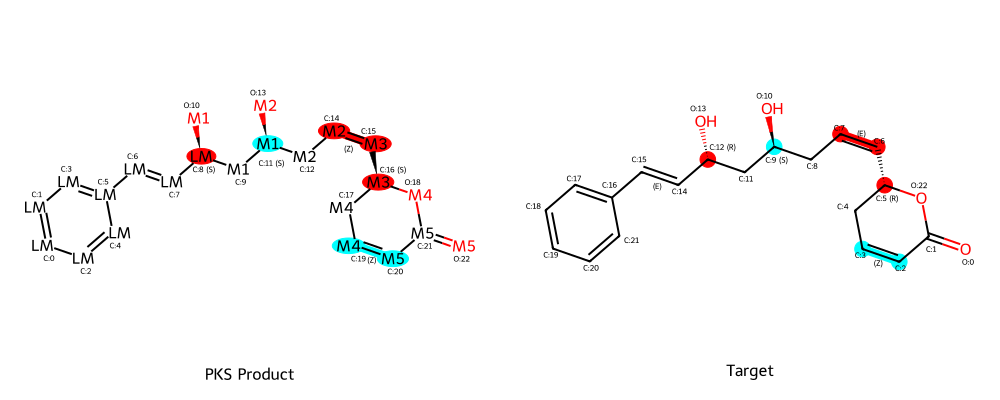

In [43]:
visualize_stereo_correspondence(unbound_mol, target_mol, chiral_results, alkene_results)

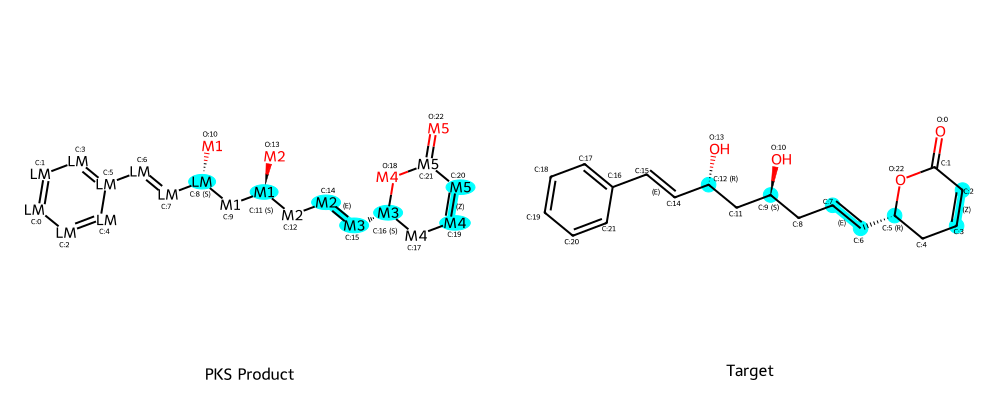

In [44]:
visualize_stereo_correspondence(final_product, target_mol, chiral_results_f, alkene_results_f)

In [45]:
new_design

[["AT{'substrate': 'cin'}", 'loading: True'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", "DH{'type': 'E'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", "DH{'type': 'Z'}", 'loading: False']]